In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pywt # pip install pywavelets

try:
    import cPickle
except:
    import pickle as cPickle

import os
import re
import numpy as np
import scipy.interpolate as scinterpolate
import matplotlib.pyplot as plt

from ipywidgets import interact
from scipy import signal


In [2]:
def interpolate(x, y, dt):
    x = np.array(x)
    y = np.array(y)

    f = scinterpolate.interp1d(x, y, kind='linear')

    newx = np.arange(x.min(), x.max(),step=dt)
    newy = f(newx)
    
    return newx, newy

In [3]:
from scipy.signal import butter, lfilter


def butter_bandpass(lowcut, highcut, fs, order=5):
 nyq = 0.5 * fs
 low = lowcut / nyq
 high = highcut / nyq
 b, a = butter(order, [low, high], btype='band')
 return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
   b, a = butter_bandpass(lowcut, highcut, fs, order=order)
   y = lfilter(b, a, data)
   return y

In [4]:
def load_result(paramset='ParameterSetBase', dt=0.1, sniff_count=3):
    result_dir = os.path.join('..', 'results', paramset)
    
    with open(os.path.join(result_dir, 'input_times.pkl')) as f:
        input_times = cPickle.load(f)
        input_times.sort(key=lambda row: row[0])

    events = {}
    for entry in input_times:
        seg_name = entry[0]
        seg_times = events.get(seg_name,[])
        events[seg_name] = seg_times + entry[1]

    
    with open(os.path.join(result_dir, 'soma_vs.pkl')) as f:
        vs = cPickle.load(f)
        vs.sort(key=lambda row: row[0][0:2])
        
    with open(os.path.join(result_dir, 'lfp.pkl')) as f:
        t, lfp = cPickle.load(f)
        t = np.array(t)
        lfp = np.array(lfp)
        t, lfp = interpolate(t,lfp, dt)
               
    # Band pass filter LFP
    lfp_bp = butter_bandpass_filter(lfp, 30, 120, 1/dt*1000, order=4)
    
        
    # Wavelet decomposition
    wavelet="cgau5"
    scale_low=3     # 140 Hz
    scale_high=32   # 20 Hz
    
    scales = np.linspace(scale_low/dt, scale_high/dt, 50)     
    cfs, frequencies = pywt.cwt(lfp_bp, scales, wavelet, dt / 1000.0)
    lfp_wavelet_power = np.log(1+abs(cfs))
    
    # Average spectrum across sniffs
    sniff_duration = 200
    skip_first_n_sniffs = 1
    num_sniffs = sniff_count
    
    step = int(round(sniff_duration / dt))
    lfp_wavelet_power_average = sum([lfp_wavelet_power[:,i*step:(i+1)*step-2] for i in range(num_sniffs+skip_first_n_sniffs)[skip_first_n_sniffs:]])
    t_average = t[0:step-2]
    
    return events, vs, t, lfp, lfp_bp, lfp_wavelet_power, frequencies, t_average, lfp_wavelet_power_average
    
def show_plots(paramset='ParameterSetBase',sniff_count=3):

    fig_width = 27
    dt = 0.1 # ms
    
    events, vs, t_lfp, lfp, lfp_bp, lfp_wavelet_power, \
        frequencies, t_average, lfp_wavelet_power_average = load_result(paramset, dt, sniff_count)    
        
    i = 0
    plt.subplots(figsize=(fig_width, len(vs)*0.1))
    for cell, t, v in vs:
        if 'MC' in cell:
            col = 'blue'
        if 'TC' in cell:
            col = 'red'
        if 'GC' in cell:
            col = 'orange'
            continue # don't plot GCs
            
        plt.plot(t,np.array(v)+i,col,label=cell)
        i += 100
    
    events = [(seg, times) for seg, times in events.items()]
    events.sort(key=lambda row: row[0])
    
    for seg, times in events:
        if 'MC' in seg:
            col = 'b'
        if 'TC' in seg:
            col = 'r'
        plt.plot(times, [i]*len(times),col+'|',ms=5,label=seg)

        i += 10
    
    plt.xticks(np.arange(min(t), max(t)+1, 50.0))
    plt.margins(0)    
    plt.yticks([])
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.xlabel('Simulation Time [ms]')
    plt.show()

    t = t_lfp

    # Plot raw LFP
    plt.subplots(figsize=(fig_width, 5))
    plt.margins(0)
    plt.plot(t,lfp*1000)    
    
    
    # Plot BP filtered LFP
    plt.plot(t,lfp_bp*10000-200)    
    plt.xticks(np.arange(min(t), max(t)+1, 50.0))
    plt.yticks([])
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.xlabel('Simulation Time [ms]')
    plt.show()
    
    plt.subplots(figsize=(fig_width, 5))
    plt.contourf(t, frequencies, lfp_wavelet_power, 256,cmap='jet')
    plt.ylim((20,140))
    plt.xticks(np.arange(round(min(t)), max(t)+1, 50.0))
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Simulation Time [ms]')
    plt.show()
    
    plot_sniff_average(t_average, frequencies, lfp_wavelet_power_average)
    
def plot_sniff_average(t_average, frequencies, lfp_wavelet_power_average, show=True, yaxis=True, xlabel=True):
    if show:
        plt.subplots(figsize=(4, 5))
        
    plt.contourf(t_average, frequencies, lfp_wavelet_power_average, 256,cmap='jet')
    plt.ylim((20,140))
    
    if yaxis:
        plt.ylabel('Frequency [Hz]')   
    else:
        cur_axes = plt.gca()
        cur_axes.axes.get_yaxis().set_visible(False)
    
    if xlabel:
        plt.xlabel('Time Since Sniff Onset [ms]')
    
    
    plt.xticks(np.arange(round(min(t_average)), max(t_average)+1, 50.0)[:-1])
    
    if show:
        plt.show()
    
def plot_average_vs_paramsets(sets, labels=None, sniff_count=3):
    count = len(sets)
    
    #fig = plt.figure()
    plt.subplots(figsize=(count*4, 5))
    
    for i, paramset in enumerate(sets):
        plt.subplot(1, count, i+1)
        
        dt = 0.1 # ms
        
        events, vs, t_lfp, lfp, lfp_bp, lfp_wavelet_power, \
            frequencies, t_average, lfp_wavelet_power_average = load_result(paramset, dt, sniff_count) 
        
        plot_sniff_average(t_average, frequencies, lfp_wavelet_power_average, show=False, yaxis=i==0,xlabel=i==count/2)
        if labels is not None:
            plt.title(labels[i])

    
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    

In [9]:
!cd ..; python runbatch.py

Starting paramset: GammaSignature (1/5)...
numprocs=16
Rank Complexity min: 551, mean: 662.625, max: 791
Starting simulation...
Time: 1800.0 ms
Starting paramset: GammaSignature_NoInhibition (2/5)...
numprocs=16
Rank Complexity min: 551, mean: 662.625, max: 791
Starting simulation...
Time: 1800.0 ms
Starting paramset: GammaSignature_NoTCGJs (3/5)...
numprocs=16
Rank Complexity min: 551, mean: 662.625, max: 791
Starting simulation...
Time: 1800.0 ms
Starting paramset: GammaSignature_NoMCGJs (4/5)...
numprocs=16
Rank Complexity min: 551, mean: 662.625, max: 791
Starting simulation...
Time: 1800.0 ms
Starting paramset: GammaSignature_EqualTCMCInputs (5/5)...
numprocs=16
Rank Complexity min: 551, mean: 662.625, max: 791
Starting simulation...
Time: 1800.0 ms


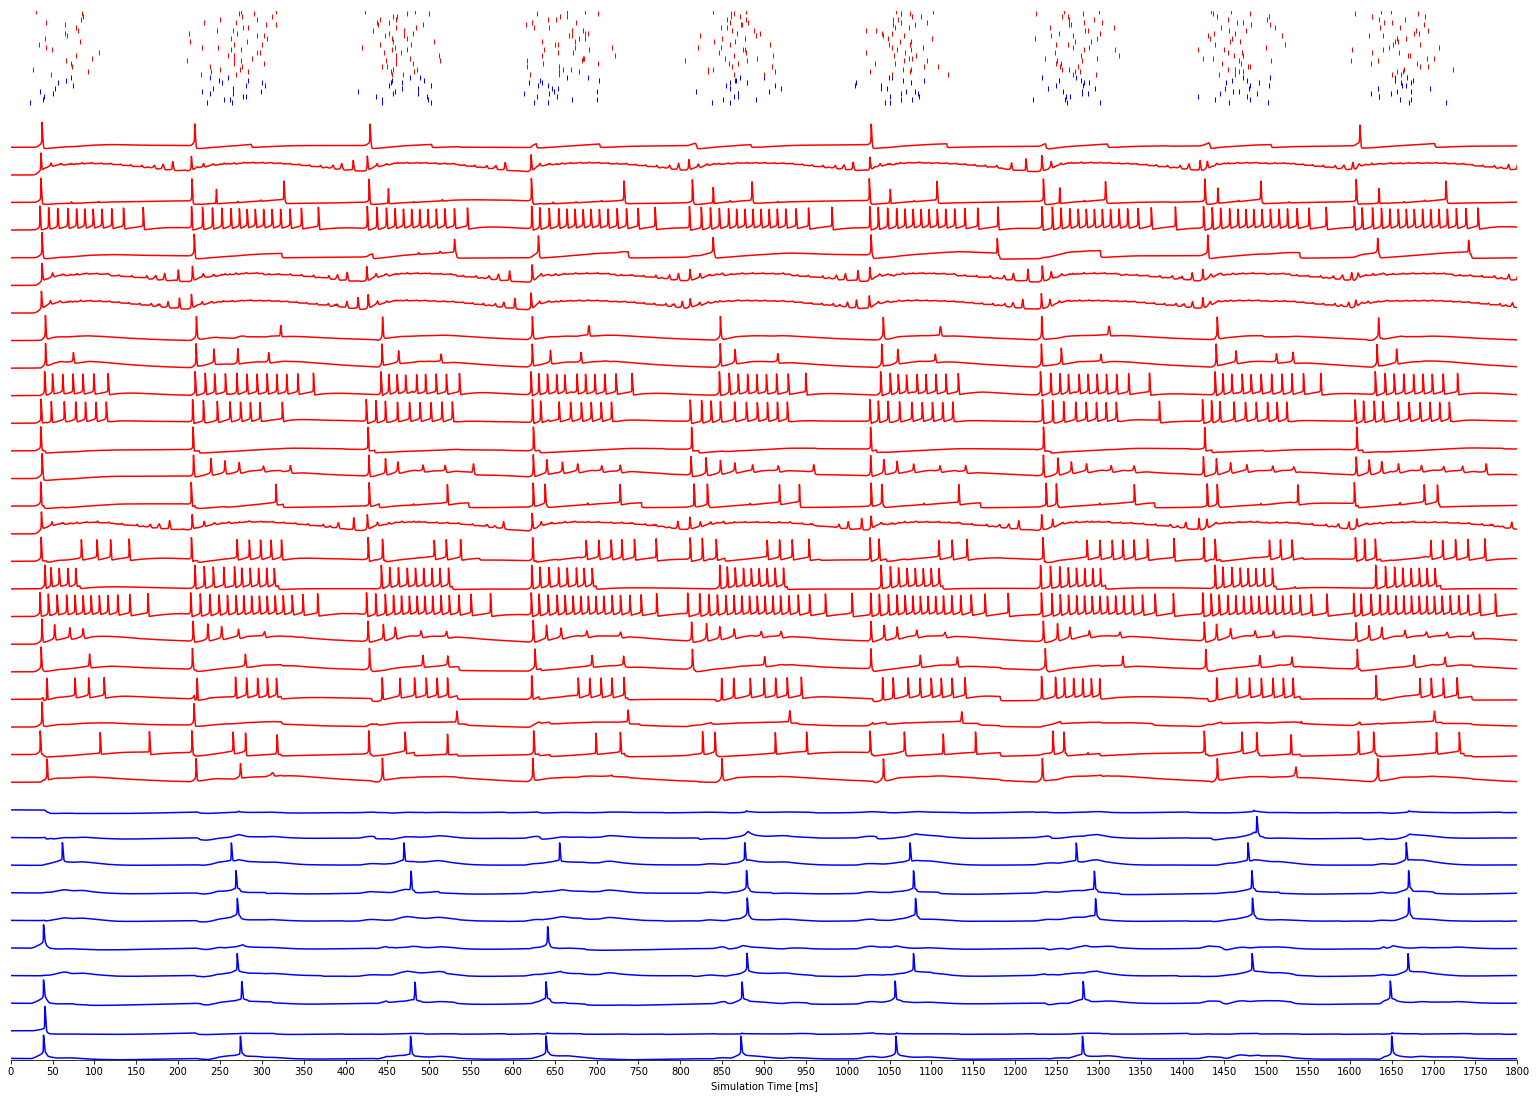

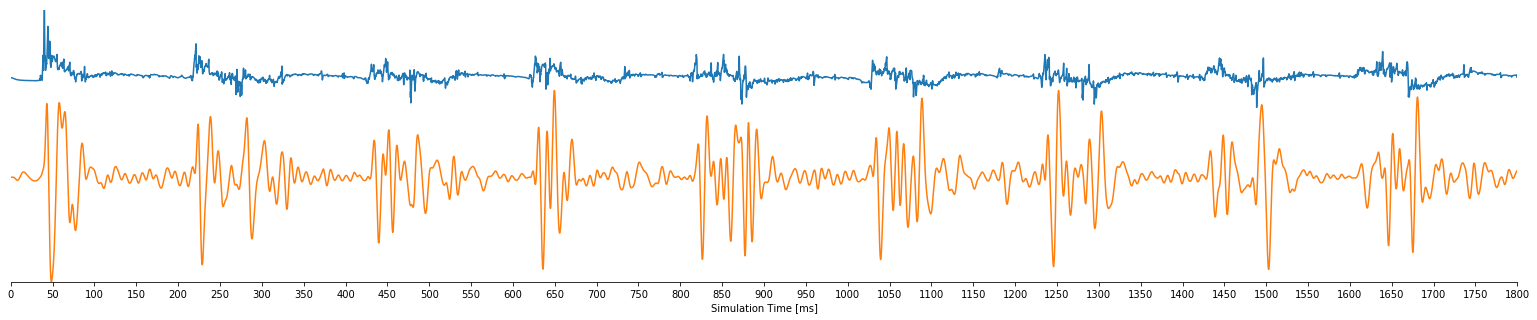

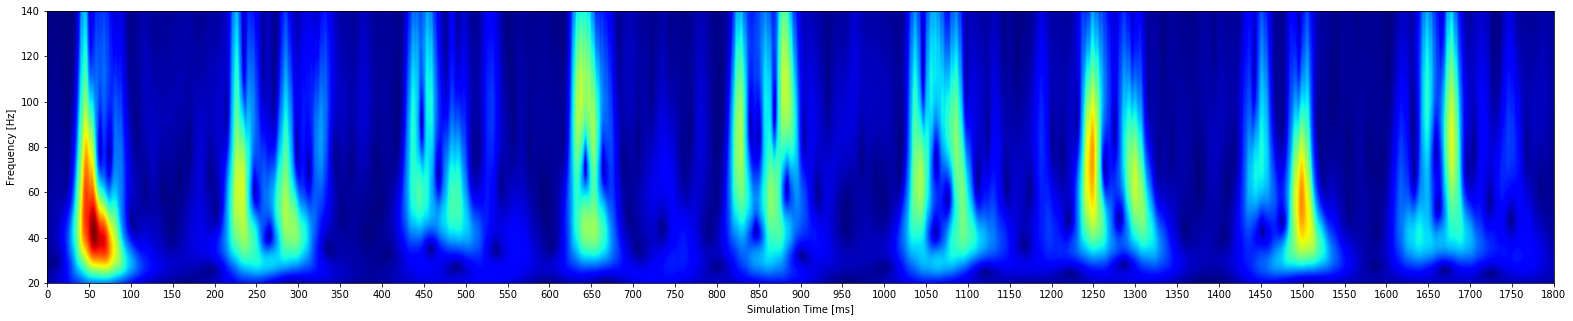

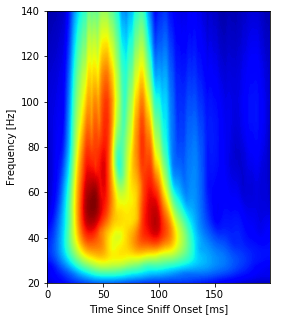

In [10]:
show_plots('GammaSignature', sniff_count=8)

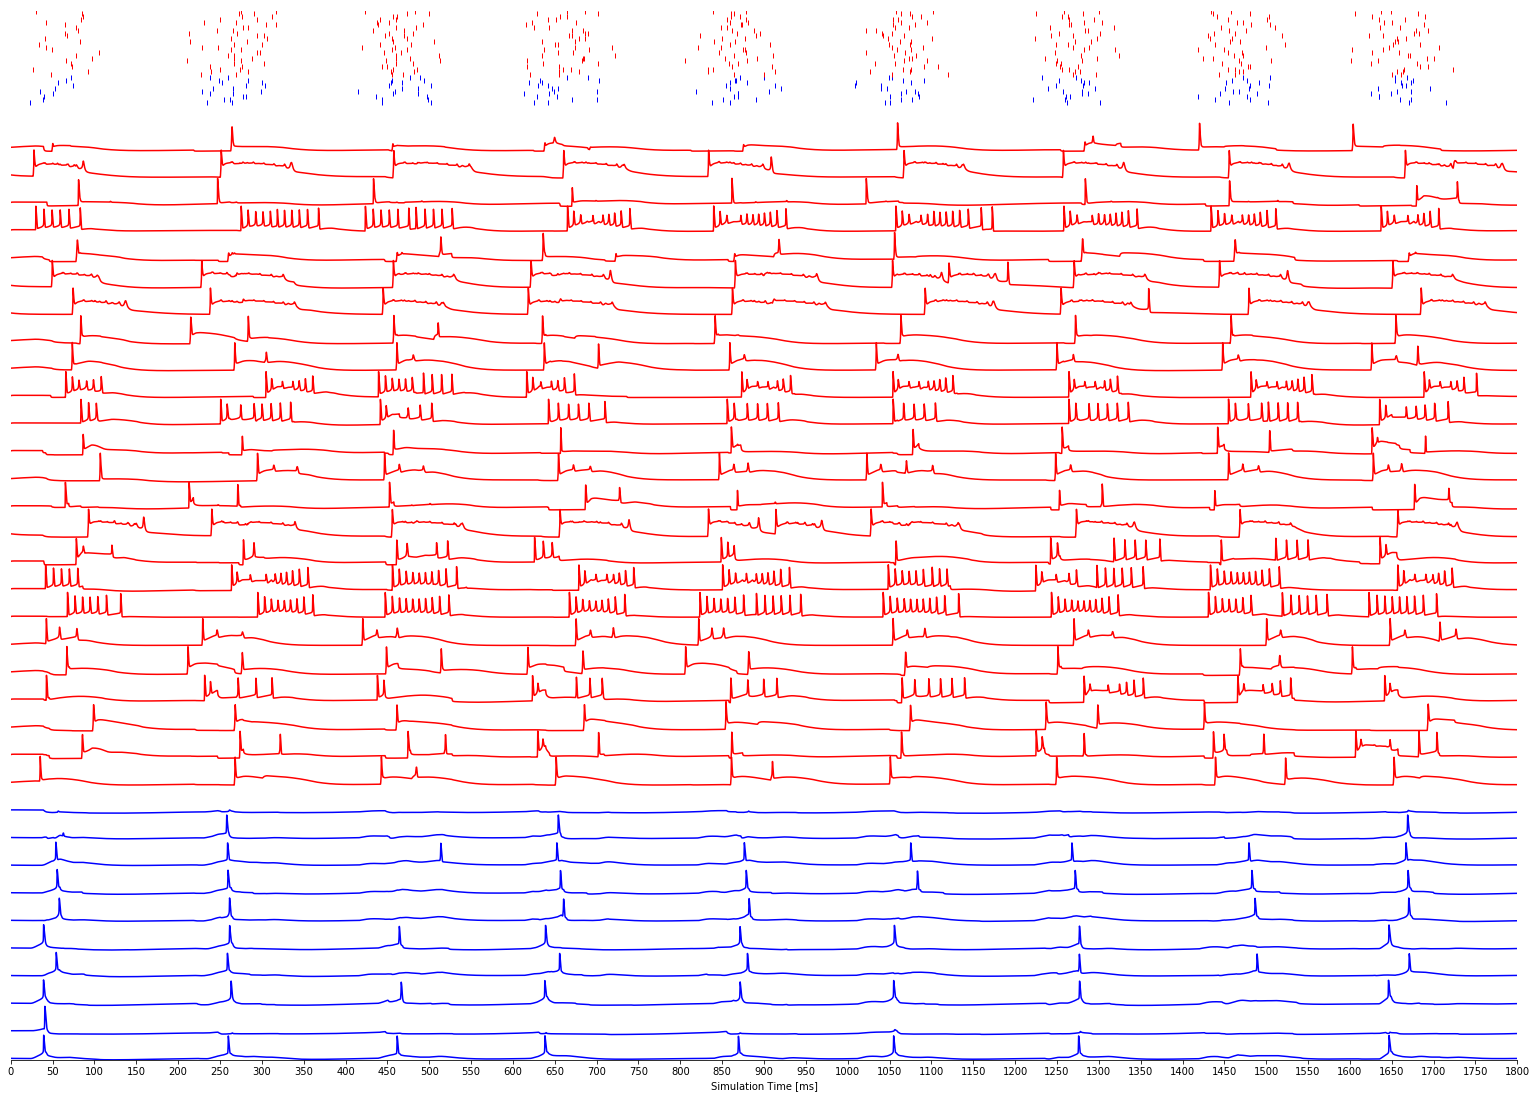

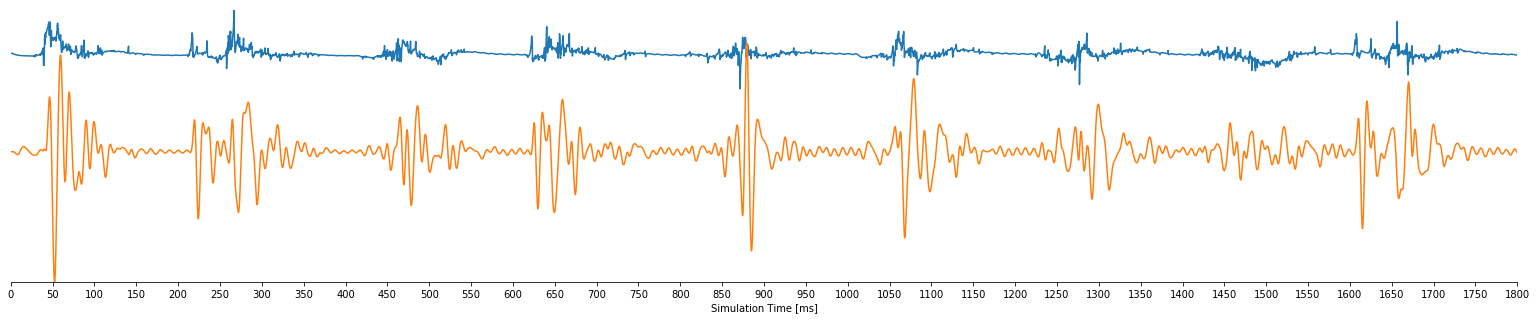

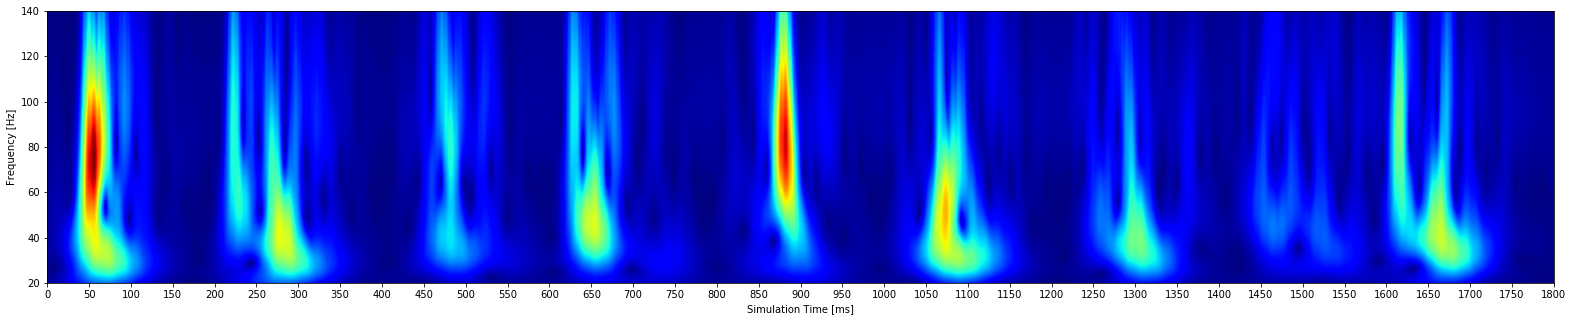

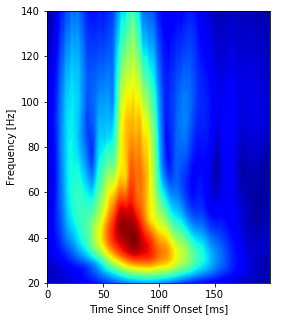

In [11]:
show_plots('GammaSignature_NoTCGJs', sniff_count=8)

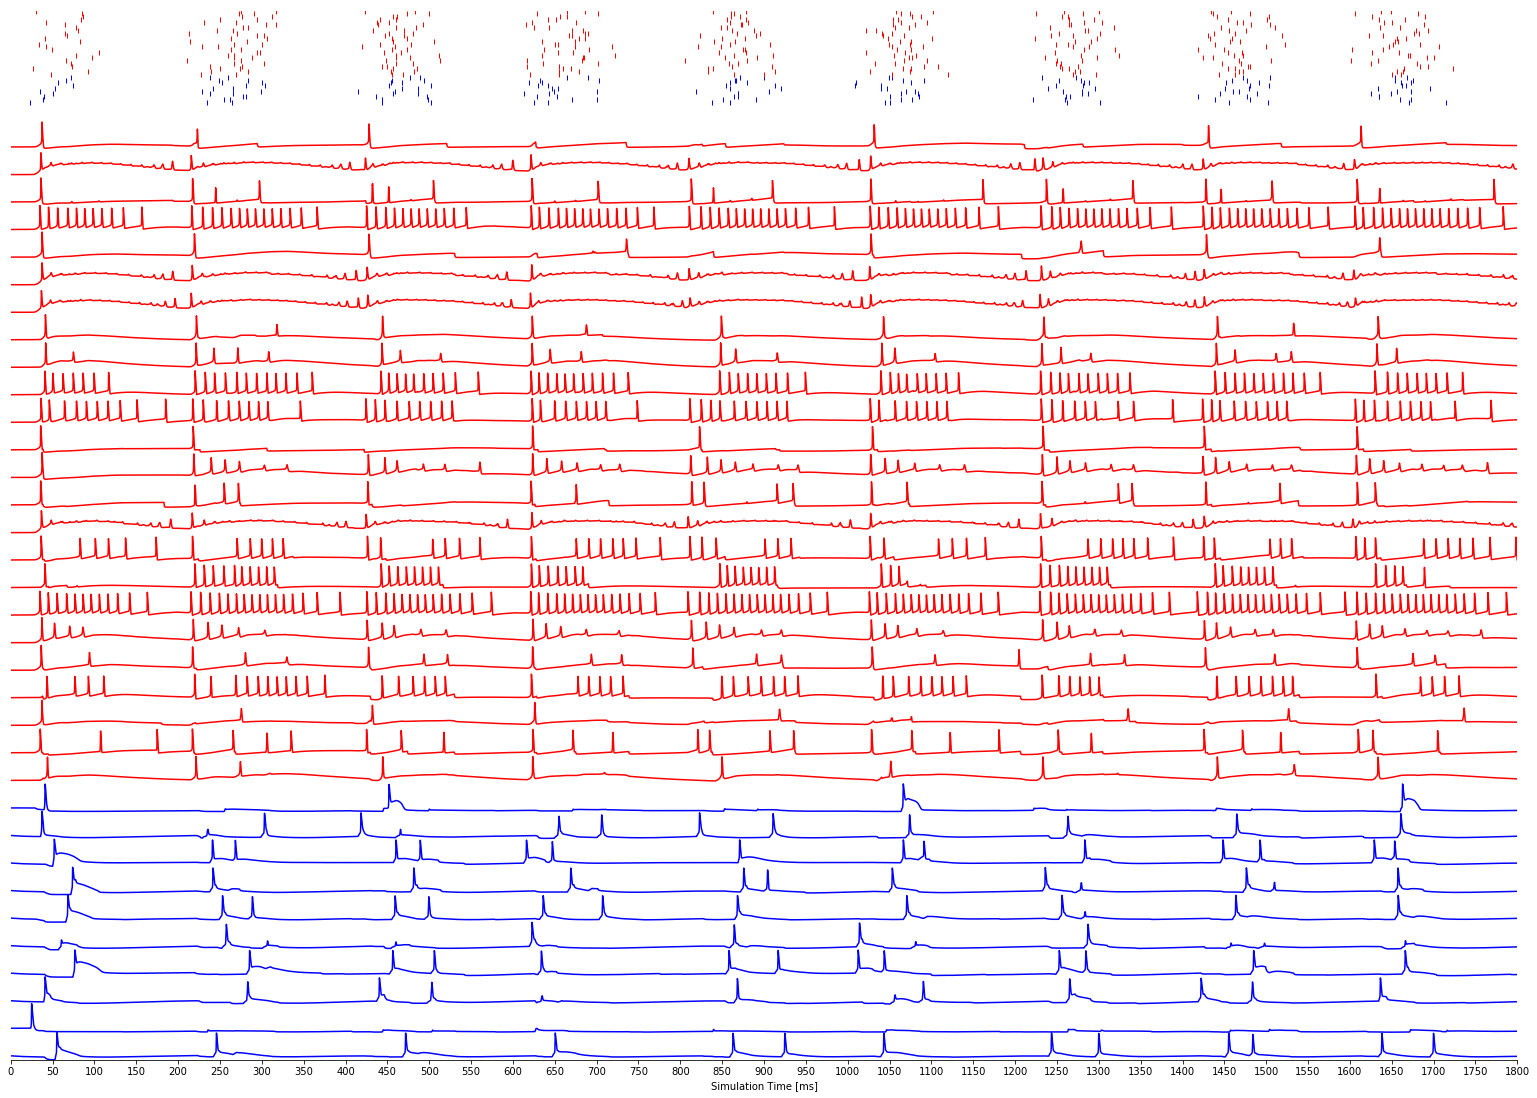

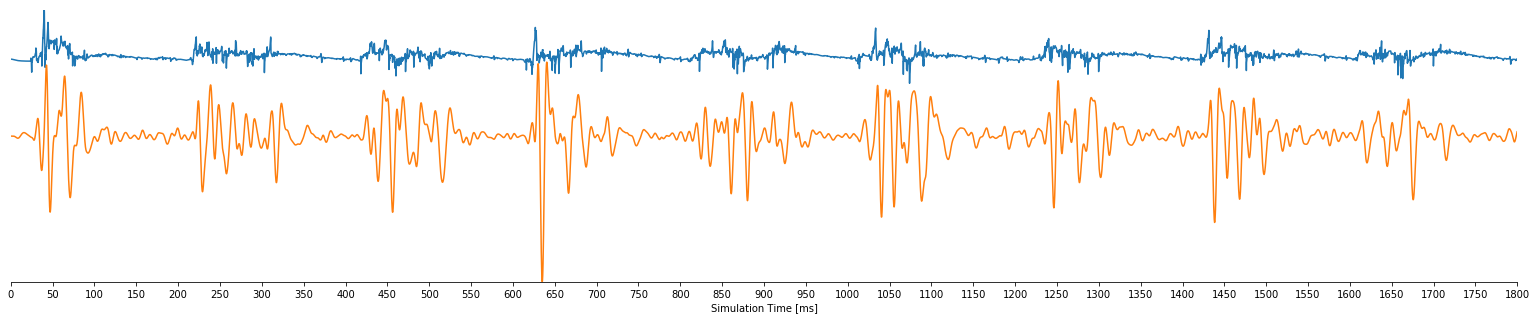

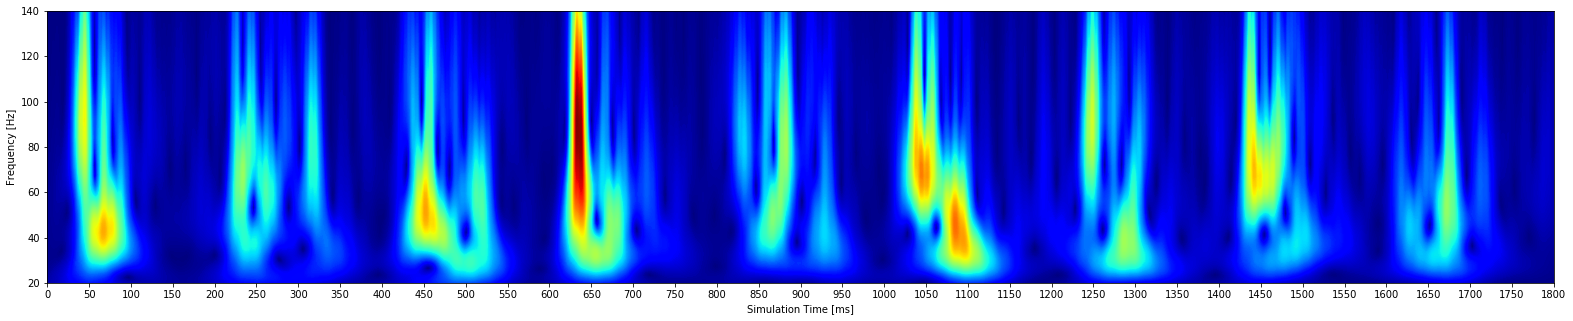

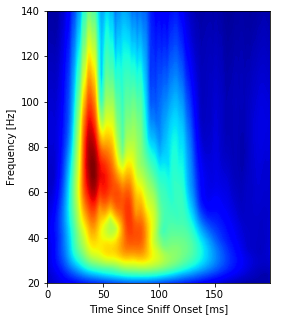

In [12]:
show_plots('GammaSignature_NoMCGJs', sniff_count=8)

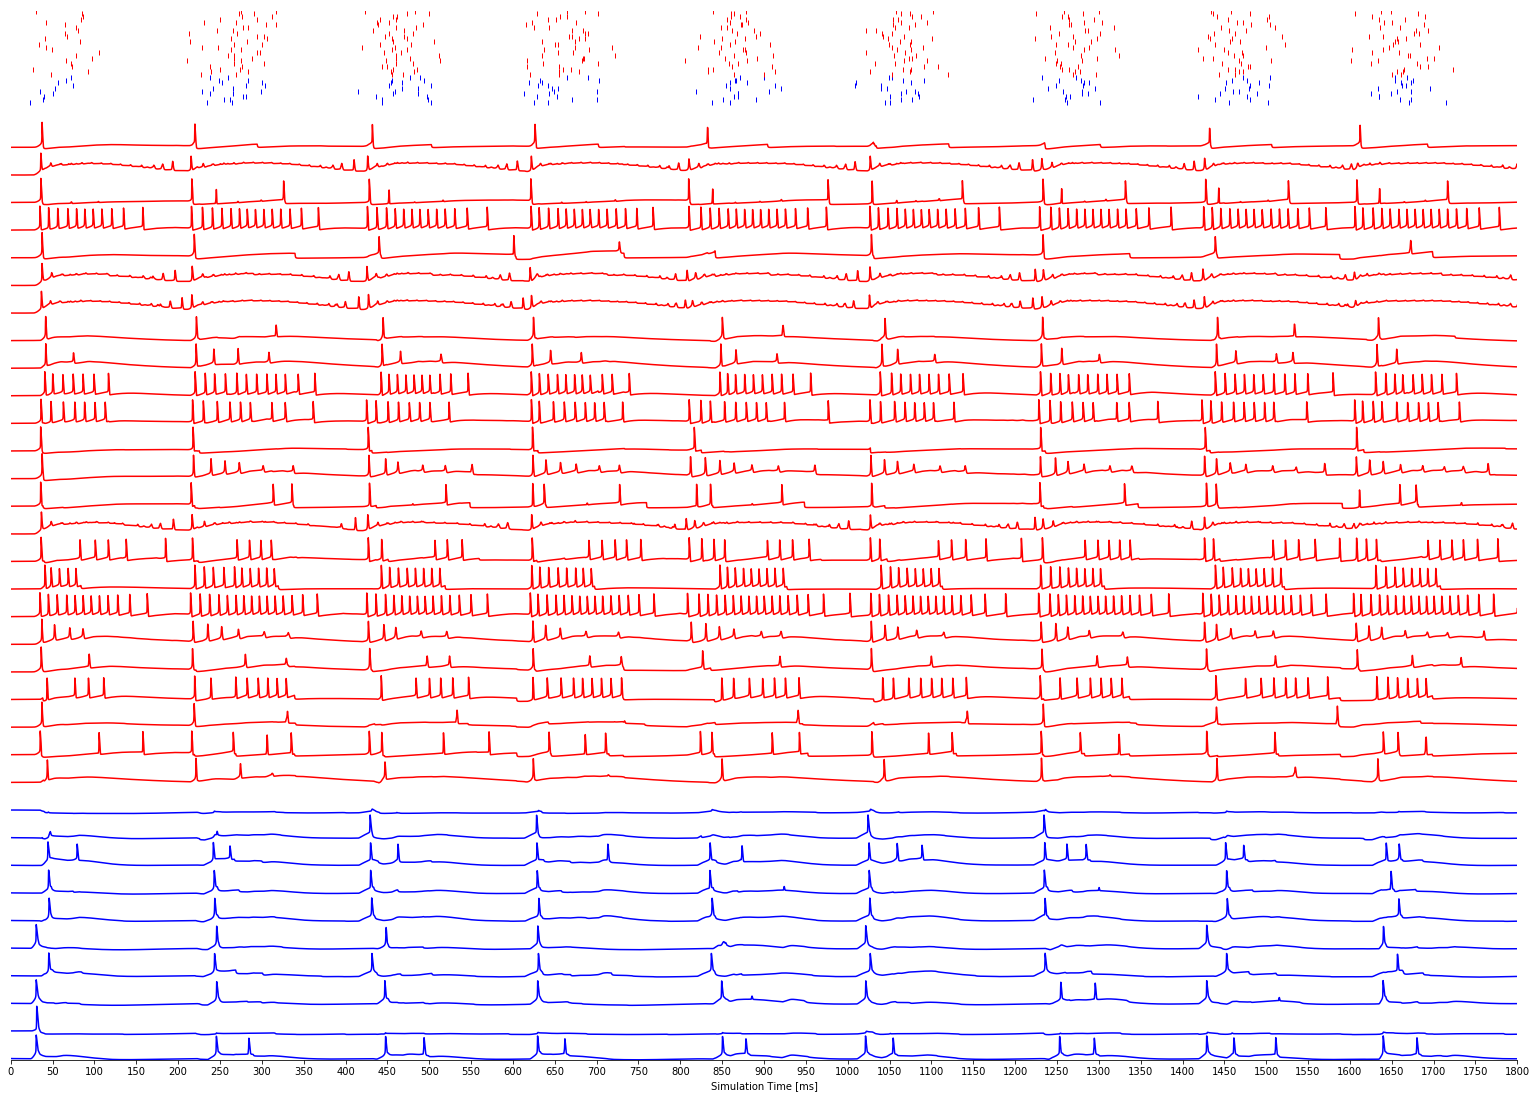

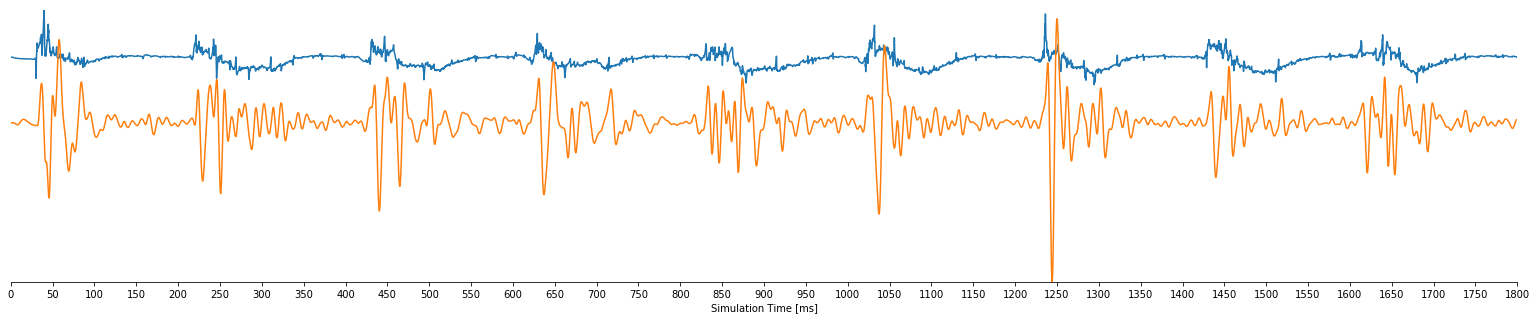

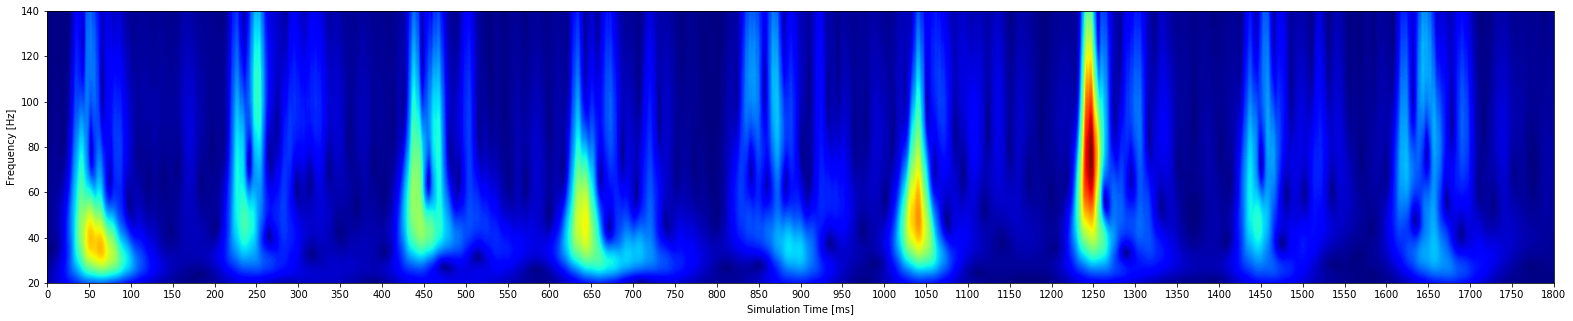

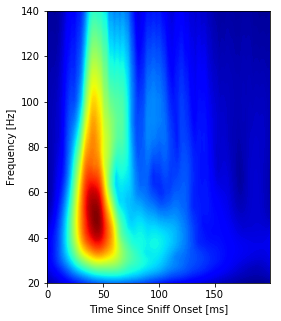

In [13]:
show_plots('GammaSignature_EqualTCMCInputs', sniff_count=8)

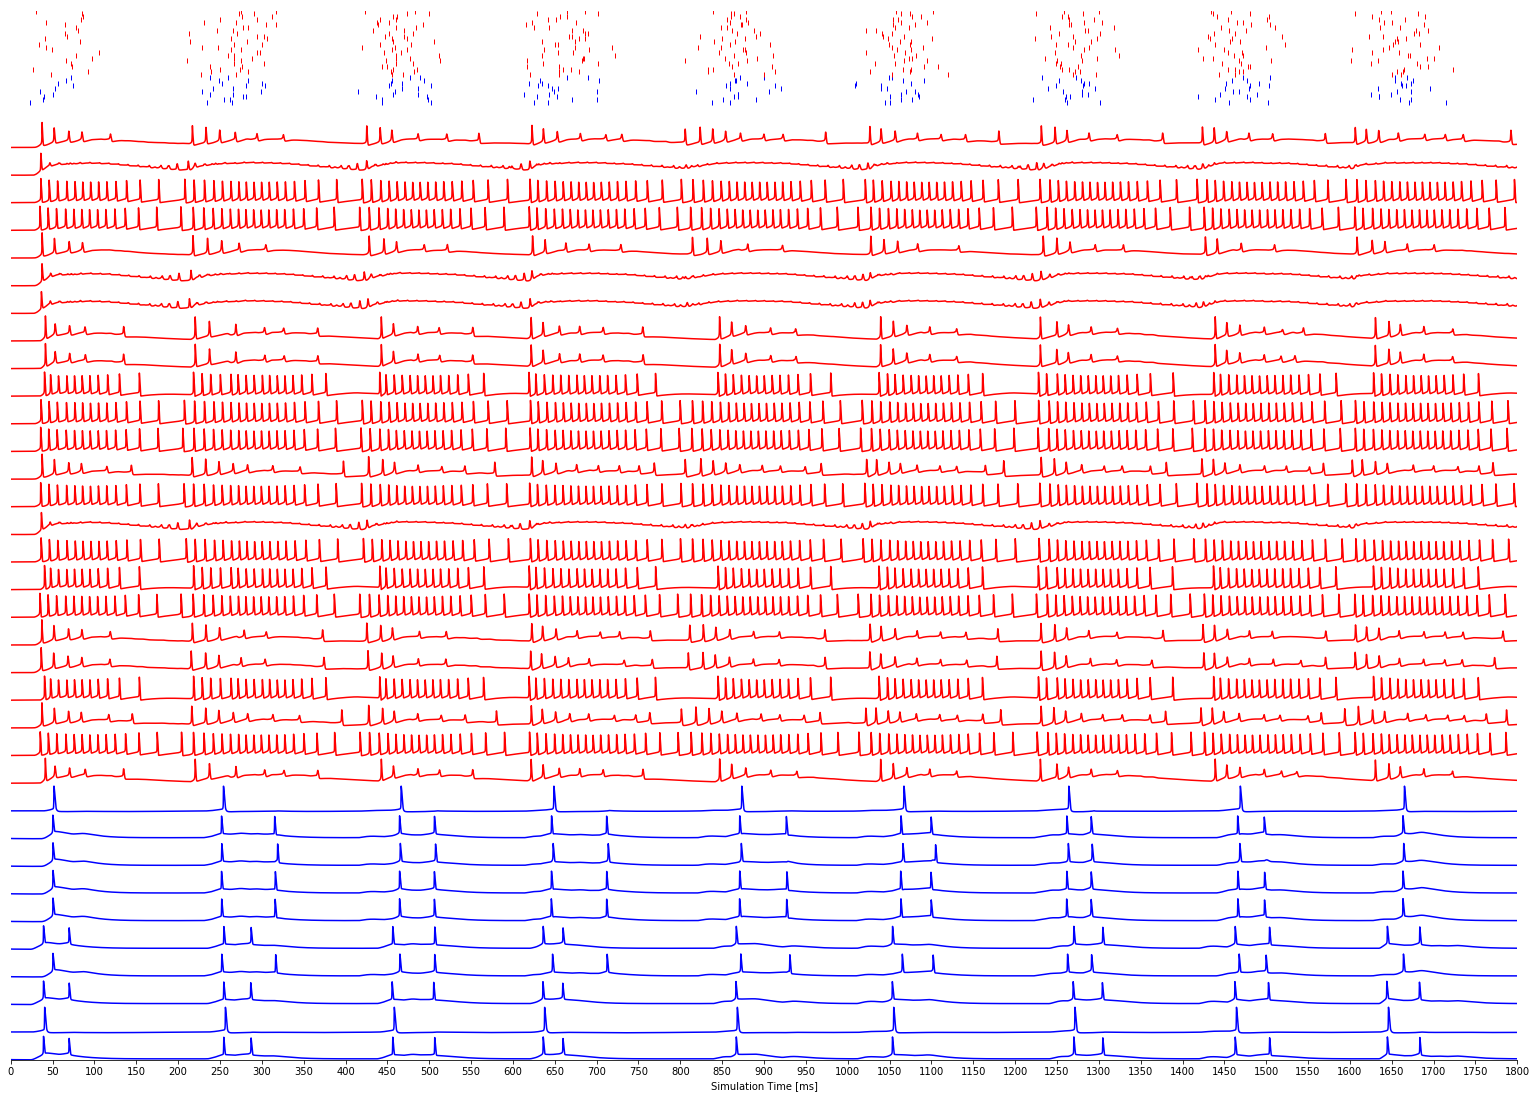

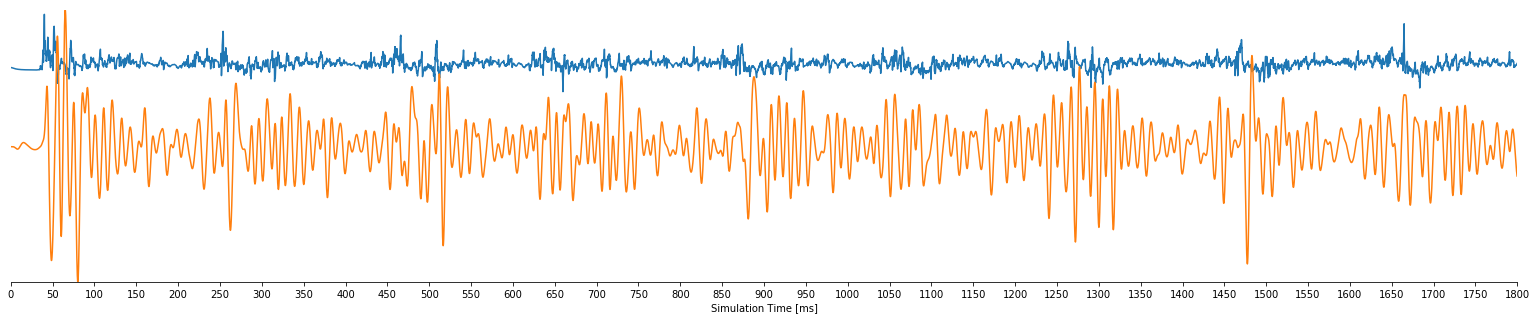

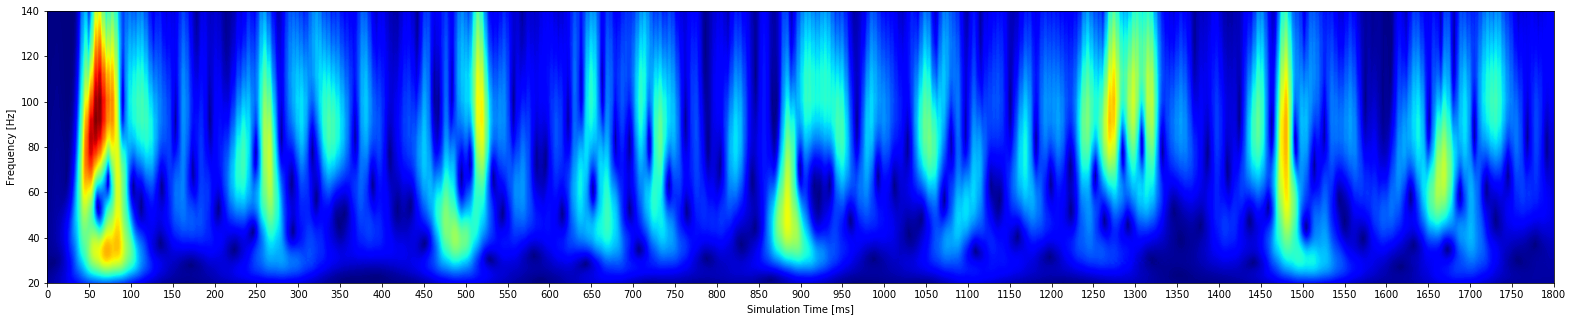

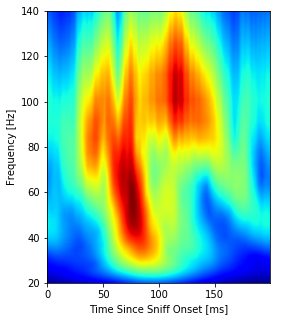

In [14]:
show_plots('GammaSignature_NoInhibition', sniff_count=8)